In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls

drive  sample_data


## Uncomment this code to download the dataset

In [ ]:
#!wget https://isic-challenge-data.s3.amazonaws.com/2020/ISIC_2020_Training_JPEG.zip
#import shutil
#shutil.unpack_archive('ISIC_2020_Training_JPEG.zip', 'data/')


## Importing all the necessary libraries

In [2]:

import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm
%matplotlib inline
#from keras.preprocessing import image
import tensorflow.keras.applications.densenet as dense
import seaborn as sns

## Reading and Visualizing the csv file of data

In [3]:
data=pd.read_csv('drive/MyDrive/Vision/data/ISIC_2020_Training_GroundTruth_v2.csv')


In [4]:
data.head(10)

,image_name,patient_id,lesion_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,IL_7972535,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,IL_4649854,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,IL_9087444,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,IL_4255399,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,IL_6898037,female,55.0,upper extremity,unknown,benign,0
5,ISIC_0074311,IP_2950485,IL_3593551,female,40.0,lower extremity,unknown,benign,0
6,ISIC_0074542,IP_4698288,IL_5017890,male,25.0,lower extremity,unknown,benign,0
7,ISIC_0075663,IP_6017204,IL_1711395,female,35.0,torso,unknown,benign,0
8,ISIC_0075914,IP_7622888,IL_8599857,male,30.0,torso,unknown,benign,0
9,ISIC_0076262,IP_5075533,IL_8541111,female,50.0,lower extremity,unknown,benign,0


## We plot the total number of Benign and Melanoma cases.
## We can observe from the plot that our dataset is highly imbalanced as it only contain 584 samples of melanoma

In [5]:
data['benign_malignant'].value_counts()


benign       32542
malignant      584
Name: benign_malignant, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


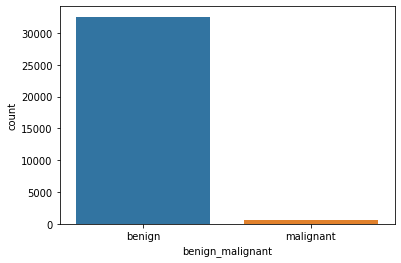

In [6]:
benign_malignant=data['benign_malignant']
sns.countplot(benign_malignant)


## Measure the total samples of male and female
## Plot the male and female samples 

Male Cases Data =  True     17080
False    16046
Name: sex, dtype: int64
female Cases Data =  False    17145
True     15981
Name: sex, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


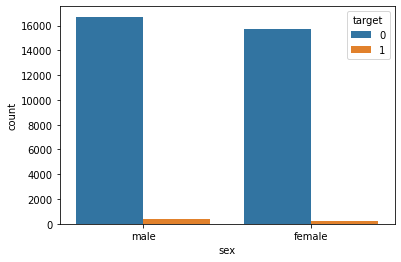

In [7]:
male_target=(data['sex']=='male').value_counts()
female_target=(data['sex']=='female').value_counts()

print('Male Cases Data = ',male_target)
print('female Cases Data = ',female_target)

sns.countplot(data['sex'], hue=data['target'])


## Measure the age variation of persons in the data having melanoma or benign cases

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


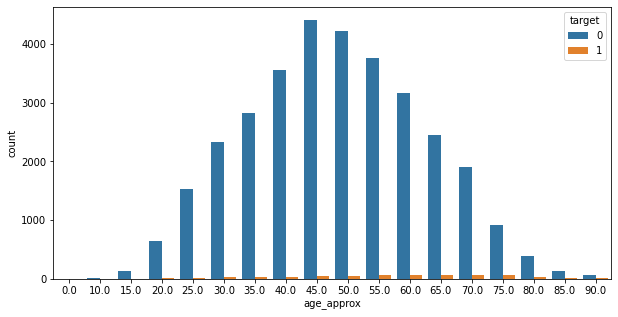

In [8]:
plt.figure(figsize=(10,5))
sns.countplot(data['age_approx'], hue=data['target'])

## Plot for visualizing the body part where the observational disease occurs.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


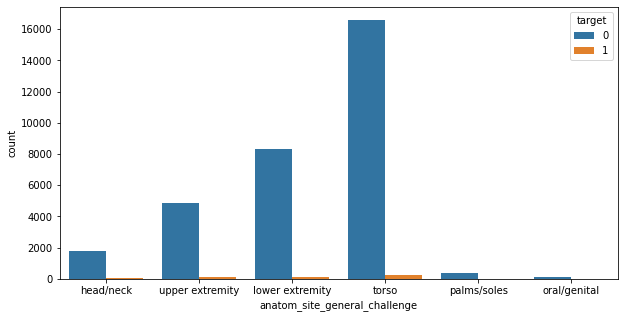

In [9]:
plt.figure(figsize=(10,5))
sns.countplot(data['anatom_site_general_challenge'], hue=data['target'])

## Types of cancers detected in observations

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


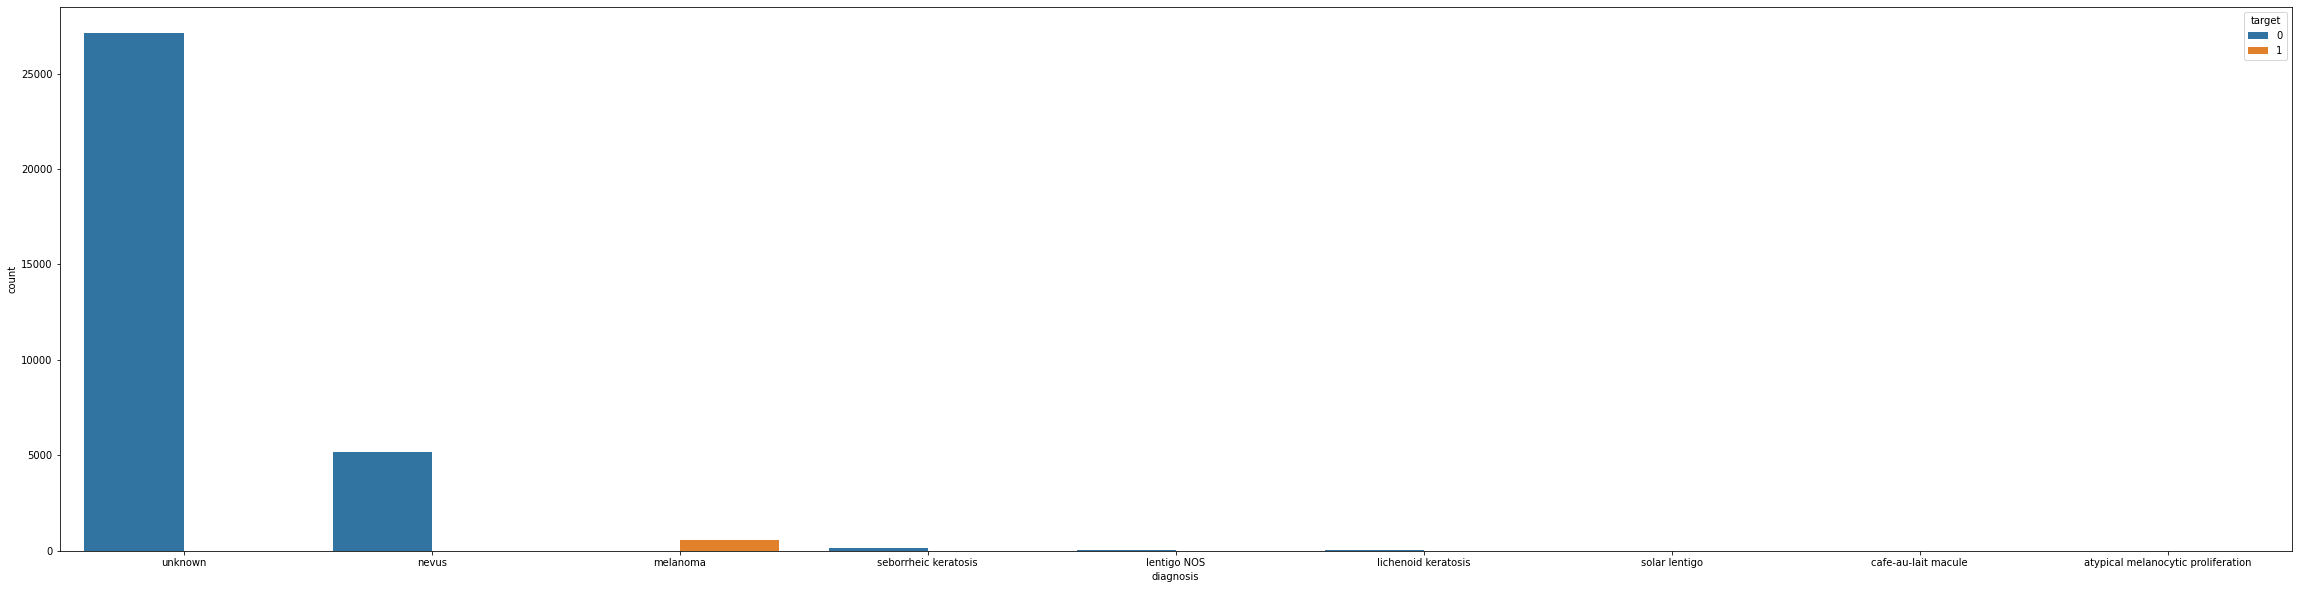

In [10]:
plt.figure(figsize=(40,10))
sns.countplot(data['diagnosis'], hue=data['target'])


## Function for generating plot

In [16]:
def plot_img(img_list):
  import numpy as np
  import matplotlib.pyplot as plt

  plott = plt.figure(figsize=(8, 8))
  columns = 4
  rows = 5
  count=0
  for i in img_list:
      count=count+1
      
      plott.add_subplot(rows,columns,count)
      plt.imshow(i)
  plt.show()

## Visualize some of Melanoma Images

drive/MyDrive/Vision/data/train/ISIC_4523382.jpg
drive/MyDrive/Vision/data/train/ISIC_3341710.jpg
drive/MyDrive/Vision/data/train/ISIC_9164054.jpg
drive/MyDrive/Vision/data/train/ISIC_2176112.jpg
drive/MyDrive/Vision/data/train/ISIC_0280912.jpg
drive/MyDrive/Vision/data/train/ISIC_5216586.jpg
drive/MyDrive/Vision/data/train/ISIC_7489564.jpg
drive/MyDrive/Vision/data/train/ISIC_9967383.jpg


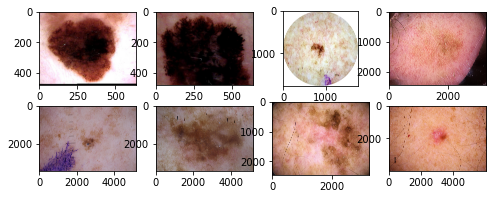

In [17]:
from google.colab.patches import cv2_imshow
img_list = data[data['target'] == 1].sample(8)['image_name']
img_l=[]
for i in img_list:
    
    image_file = 'drive/MyDrive/Vision/data/train/'+i+'.jpg' 
    print(image_file)
    img =  np.array(Image.open(image_file))
    img_l.append(img)
    
plot_img(img_l)
    

## Visualize some of Non-Melanoma Images

drive/MyDrive/Vision/data/train/ISIC_5932182.jpg
drive/MyDrive/Vision/data/train/ISIC_6166810.jpg
drive/MyDrive/Vision/data/train/ISIC_0295820.jpg
drive/MyDrive/Vision/data/train/ISIC_0175364.jpg
drive/MyDrive/Vision/data/train/ISIC_4965832.jpg
drive/MyDrive/Vision/data/train/ISIC_1338069.jpg
drive/MyDrive/Vision/data/train/ISIC_5967053.jpg
drive/MyDrive/Vision/data/train/ISIC_3230018.jpg


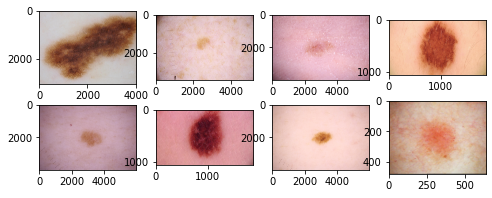

In [18]:
from google.colab.patches import cv2_imshow
img_list = data[data['target'] == 0].sample(8)['image_name']
img_l=[]
for i in img_list:
    
    image_file = 'drive/MyDrive/Vision/data/train/'+i+'.jpg' 
    print(image_file)
    img =  np.array(Image.open(image_file))
    img_l.append(img)
    
plot_img(img_l)
